In [ ]:
%run '../src/imports.py'

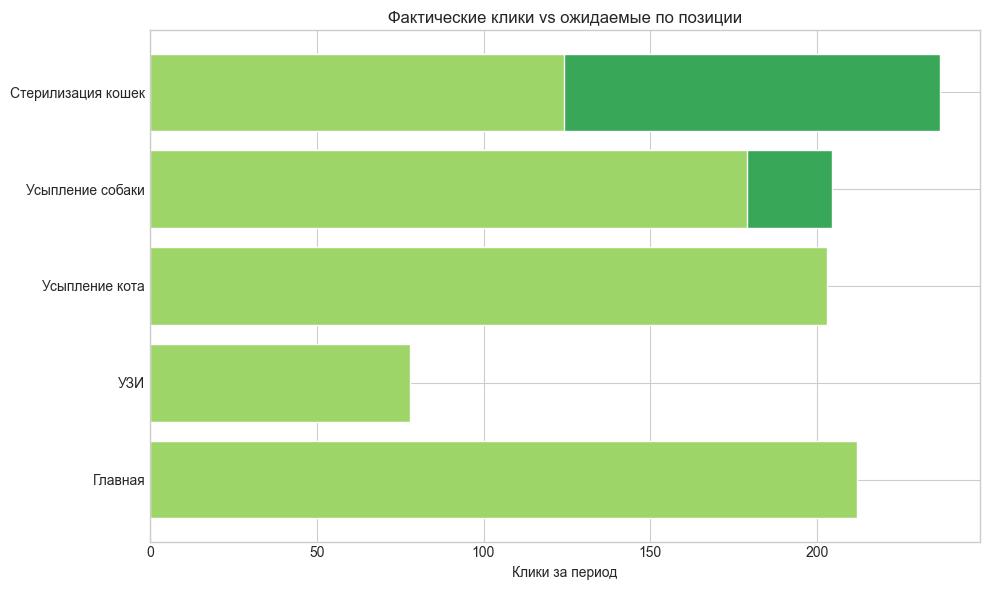

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Пример данных (можно заменить на CSV из GSC)
data = [
    ['Стерилизация кошек', 9.94, 9478, 124],
    ['Усыпление собаки', 7.92, 8174, 179],
    ['Усыпление кота', 8.92, 5609, 203],
    ['Главная', 16.95, 6717, 212],
    ['УЗИ', 18.98, 1150, 78],
]

df = pd.DataFrame(data, columns=[
    'page', 'position', 'impressions', 'clicks'
])

# Бенчмарк CTR
def expected_ctr(pos):
    if pos <= 1: return 0.25
    if pos <= 2: return 0.14
    if pos <= 3: return 0.09
    if pos <= 5: return 0.045
    if pos <= 10: return 0.025
    if pos <= 20: return 0.012
    return 0.004

df['expected_ctr'] = df['position'].apply(expected_ctr)
df['expected_clicks'] = df['impressions'] * df['expected_ctr']

# Сортируем по потенциалу
df['potential'] = df['expected_clicks'] - df['clicks']
df = df.sort_values('potential', ascending=False)

# ──── Визуализация ─────────────────────────────
plt.figure(figsize=(10, 6))

plt.barh(df['page'], df['expected_clicks'])
plt.barh(df['page'], df['clicks'])

plt.xlabel('Клики за период')
plt.title('Фактические клики vs ожидаемые по позиции')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Анализируем 22 страниц | Суммарные показы: 75,793 | клики: 1,553

Результаты расчёта Poisson CDF (сортировка по возрастанию CDF)
───────────────────────────────────────────────────────────────
                                               page  position  impressions  \
21                        dermatit u koshek i sobak      9.55          421   
18  esli rvota ponos u koshki ili sobaki chto delat     14.25         2284   
4                              sterilizaciya koshek      9.94         9478   
6                                  privivki koshkam      9.27         6408   
12                                             ceny      4.66          912   
20                                           uslugi      2.41          123   
11                                 kastraciya sobak      7.61         1919   
16               sobaka zabolela posle ukusa klesha     50.32         5342   
3                                  usyplenie sobaki      7.92         8174   
5                          

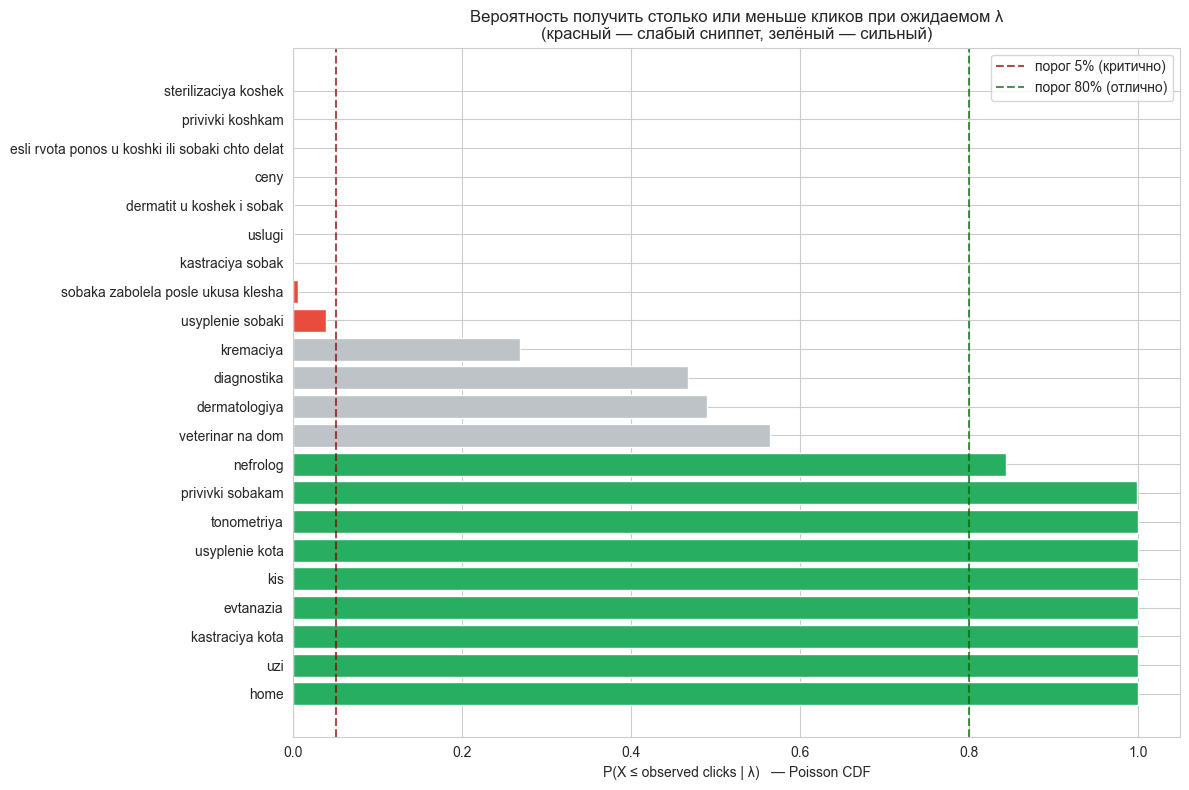


Топ-6 страниц с наиболее слабым сниппетом (по Poisson CDF):


,page,position,impressions,clicks,lambda,poisson_cdf,deviation_%,potential_gain
4,sterilizaciya koshek,9.94,9478,124,236.950,0.000,-47.668,112.950
6,privivki koshkam,9.27,6408,100,160.200,0.000,-37.578,60.200
18,esli rvota ponos u koshki ili sobaki chto delat,14.25,2284,6,27.408,0.000,-78.109,21.408
12,ceny,4.66,912,17,41.040,0.000,-58.577,24.040
21,dermatit u koshek i sobak,9.55,421,1,10.525,0.000,-90.499,9.525
20,uslugi,2.41,123,2,11.070,0.001,-81.933,9.070


In [9]:
# =============================================================================
# Расчёт Poisson CDF для анализа CTR страниц
# Цель: понять, насколько маловероятно получить текущее число кликов,
#       если бы CTR соответствовал бенчмарку позиции (2025–2026)
# =============================================================================

import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ──── 1. Загрузка датасета ─────────────────────────────────
df = pd.read_csv('../data/страницы.csv')

# Переименование колонок (на случай кириллицы и опечаток)
df = df.rename(columns={
    'Популярные страницы': 'url',
    'Kлики': 'clicks',
    'Показы': 'impressions',
    'CTR': 'ctr_str',
    'Позиция': 'position'
})

# Очистка и преобразование
df['clicks']       = pd.to_numeric(df['clicks'], errors='coerce').fillna(0).astype(int)
df['impressions']  = pd.to_numeric(df['impressions'], errors='coerce').fillna(0).astype(int)
df['position']     = pd.to_numeric(df['position'], errors='coerce')

# CTR в долях
df['ctr'] = df['ctr_str'].str.replace('%', '').astype(float) / 100

# Короткое имя страницы — только последний сегмент после /
df['page'] = df['url'].str.rstrip('/').str.split('/').str[-1]

# Главная страница (пустой сегмент) → "home"
df['page'] = df['page'].replace('', 'home')

# Дефисы → пробелы для лучшей читаемости
df['page'] = df['page'].str.replace('-', ' ')

# Фильтр: только страницы с ≥ 100 показами (чтобы Пуассон имел смысл)
df = df[df['impressions'] >= 100].copy().reset_index(drop=True)

print(f"Анализируем {len(df)} страниц | Суммарные показы: {df['impressions'].sum():,} | клики: {df['clicks'].sum():,}")

# ──── 2. Бенчмарк CTR по позиции (реалистичный 2025–2026) ───────────────────
def benchmark_ctr(pos):
    if pos <= 1:   return 0.25
    if pos <= 2:   return 0.14
    if pos <= 3:   return 0.09
    if pos <= 5:   return 0.045
    if pos <= 10:  return 0.025
    if pos <= 20:  return 0.012
    return 0.004

df['exp_ctr'] = df['position'].apply(benchmark_ctr)

# ──── 3. Ожидаемое число кликов (λ) ──────────────────────────────────────────
df['lambda'] = df['impressions'] * df['exp_ctr']

# ──── 4. Poisson CDF: P(X ≤ observed_clicks | λ) ─────────────────────────────
df['poisson_cdf'] = df.apply(
    lambda row: poisson.cdf(row['clicks'], row['lambda']) if row['lambda'] > 0 else 1.0,
    axis=1
)

# Дополнительные метрики для интерпретации
df['deviation_%']    = (df['clicks'] - df['lambda']) / df['lambda'] * 100
df['potential_gain'] = np.maximum(0, df['lambda'] - df['clicks'])

# ──── 5. Вывод результатов ───────────────────────────────────────────────────
print("\nРезультаты расчёта Poisson CDF (сортировка по возрастанию CDF)")
print("───────────────────────────────────────────────────────────────")
print(df[[
    'page', 'position', 'impressions', 'clicks',
    'lambda', 'poisson_cdf', 'deviation_%', 'potential_gain'
]].round(3).sort_values('poisson_cdf'))

print("\nИнтерпретация:")
print("• CDF < 0.05   → очень маловероятно → почти наверняка слабый сниппет")
print("• CDF < 0.20   → подозрительно низко, стоит проверить")
print("• CDF > 0.80   → кликов больше, чем ожидалось → сильный сниппет")

# ──── 6. Визуализация: барчарт Poisson CDF ───────────────────────────────────
plt.figure(figsize=(12, 8))

df_sorted = df.sort_values('poisson_cdf')

bars = plt.barh(
    df_sorted['page'],
    df_sorted['poisson_cdf'],
    color = np.where(df_sorted['poisson_cdf'] < 0.05, '#e74c3c',   # красный — проблемные
                     np.where(df_sorted['poisson_cdf'] > 0.80, '#27ae60',  # зелёный — сильные
                              '#bdc3c7'))  # серый — норма
)

plt.axvline(0.05, color='darkred', linestyle='--', alpha=0.7, label='порог 5% (критично)')
plt.axvline(0.80, color='darkgreen', linestyle='--', alpha=0.7, label='порог 80% (отлично)')
plt.xlabel('P(X ≤ observed clicks | λ)   — Poisson CDF')
plt.title('Вероятность получить столько или меньше кликов при ожидаемом λ\n(красный — слабый сниппет, зелёный — сильный)')
plt.gca().invert_yaxis()  # самые проблемные сверху
plt.legend()
plt.tight_layout()
plt.show()

# ──── 7. Топ-6 самых проблемных страниц ──────────────────────────────────────
print("\nТоп-6 страниц с наиболее слабым сниппетом (по Poisson CDF):")
df.nsmallest(6, 'poisson_cdf')[[
    'page', 'position', 'impressions', 'clicks',
    'lambda', 'poisson_cdf', 'deviation_%', 'potential_gain'
]].round(3)

In [28]:
# ──── 1. Загрузка данных из CSV ─────────────────────────────────
df = pd.read_csv('../data/страницы.csv')

In [31]:
# Очистка названий столбцов (убираем лишние пробелы)
df.columns = df.columns.str.strip()

# Переименовываем столбцы на английский для удобства
df = df.rename(columns={
    'Популярные страницы': 'url',
    'Kлики': 'clicks',
    'Показы': 'impressions',
    'CTR': 'ctr',
    'Позиция': 'position'
})

df

,url,clicks,impressions,ctr,position,url_short,type,log_impr,exp_ctr_benchmark,lambda_poisson,poisson_cdf_low,deviation_pct,deviation_abs,priority
0,/kastraciya-kota,240,12057,0.0199,11.54,Kastraciya Kota,service,9.397484,0.015,180.855,9.999884e-01,32.702994,59.145,Успешный (масштабировать)
1,/,212,6717,0.0316,16.95,,service,8.812546,0.015,100.755,1.000000e+00,110.411394,111.245,Успешный (масштабировать)
2,/usyplenie-kota,203,5609,0.0362,8.92,Usyplenie Kota,service,8.632306,0.035,196.315,6.990088e-01,3.405242,6.685,Норма
3,/usyplenie-sobaki,179,8174,0.0219,7.92,Usyplenie Sobaki,service,9.008836,0.035,286.090,6.907200e-12,-37.432277,-107.090,Высокий (фиксить)
4,/sterilizaciya-koshek,124,9478,0.0131,9.94,Sterilizaciya Koshek,service,9.156834,0.035,331.730,3.411870e-39,-62.620203,-207.730,Высокий (фиксить)
5,/evtanazia/kremaciya,116,4939,0.0235,9.90,Kremaciya,service,8.505121,0.035,172.865,2.741508e-06,-32.895612,-56.865,Высокий (фиксить)
6,/privivki-koshkam,100,6408,0.0156,9.27,Privivki Koshkam,service,8.765459,0.035,224.280,9.102238e-21,-55.412877,-124.280,Высокий (фиксить)
7,/uzi,78,1150,0.0678,18.98,Uzi,service,7.048386,0.015,17.250,1.000000e+00,352.173913,60.750,Успешный (масштабировать)
8,/privivki-sobakam,67,3701,0.0181,11.87,Privivki Sobakam,service,8.216628,0.015,55.515,9.426016e-01,20.688102,11.485,Норма
9,/evtanazia,67,1012,0.0662,8.52,Evtanazia,service,6.920672,0.035,35.420,9.999992e-01,89.158667,31.580,Успешный (масштабировать)


Анализируем 22 страниц
=== Линейная регрессия: summary ===
                            OLS Regression Results                            
Dep. Variable:                    ctr   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.385
Date:                Mon, 09 Feb 2026   Prob (F-statistic):              0.275
Time:                        13:15:08   Log-Likelihood:                 55.327
No. Observations:                  22   AIC:                            -104.7
Df Residuals:                      19   BIC:                            -101.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

,page,position,ctr,pred_ctr,residual_%
15,kis,10.23,0.0833,0.039310,4.399031
7,uzi,18.98,0.0678,0.027744,4.005594
9,evtanazia,8.52,0.0662,0.029153,3.704706
2,usyplenie kota,8.92,0.0362,0.020456,1.574375
1,home,16.95,0.0316,0.018958,1.264156



=== Потенциал LTV для страницы УЗИ ===
Доп. клики в месяц:          31 – 43
Доп. клиентов в год:         38 – 62
Доп. годовой Net LTV:        10066 – 16520 BYN


ValueError: Could not interpret value `pred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctrpred_ctr` for `x`. An entry with this name does not appear in `data`.

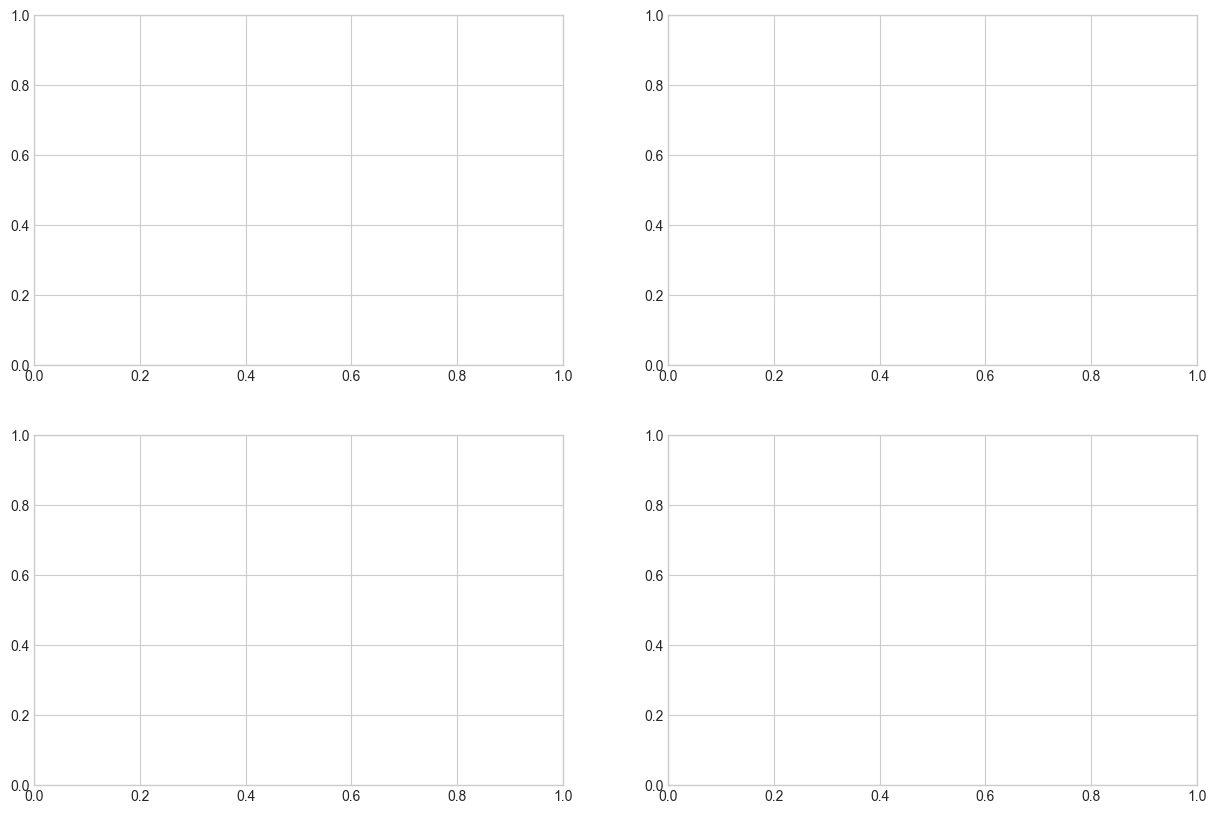

In [10]:
# =============================================================================
# Growth Case: Оптимизация страницы «УЗИ на дому» как драйвера высокого LTV
# Полный анализ на данных Google Search Console
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("RdYlGn_r")
%matplotlib inline

# ──── 1. Загрузка и подготовка данных ───────────────────────────────────────
df = pd.read_csv('../data/Страницы.csv')   # ← поменяй путь, если нужно

df = df.rename(columns={
    'Популярные страницы': 'url',
    'Kлики': 'clicks',
    'Показы': 'impressions',
    'CTR': 'ctr_str',
    'Позиция': 'position'
})

# Очистка
df['clicks'] = pd.to_numeric(df['clicks'], errors='coerce').fillna(0).astype(int)
df['impressions'] = pd.to_numeric(df['impressions'], errors='coerce').fillna(0).astype(int)
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df['ctr'] = df['ctr_str'].str.replace('%', '').astype(float) / 100

# Короткое имя страницы
df['page'] = df['url'].str.rstrip('/').str.split('/').str[-1]
df['page'] = df['page'].replace('', 'home')
df['page'] = df['page'].str.replace('-', ' ').str.strip()

# Фильтр
df = df[df['impressions'] >= 100].copy().reset_index(drop=True)

print(f"Анализируем {len(df)} страниц")

# ──── 2. Пуассон-анализ ─────────────────────────────────────────────────────
def benchmark_ctr(pos):
    if pos <= 1:   return 0.25
    if pos <= 2:   return 0.14
    if pos <= 3:   return 0.09
    if pos <= 5:   return 0.045
    if pos <= 10:  return 0.025
    if pos <= 20:  return 0.012
    return 0.004

df['exp_ctr'] = df['position'].apply(benchmark_ctr)
df['lambda'] = df['impressions'] * df['exp_ctr']

df['poisson_cdf'] = df.apply(
    lambda row: poisson.cdf(row['clicks'], row['lambda']) if row['lambda'] > 0 else 1.0, 
    axis=1
)

df['deviation_%'] = (df['clicks'] - df['lambda']) / df['lambda'] * 100
df['potential_gain_clicks'] = np.maximum(0, df['lambda'] - df['clicks'])

# ──── 3. Линейная регрессия + остатки ───────────────────────────────────────
df['log_impr'] = np.log1p(df['impressions'])

X = sm.add_constant(df[['position', 'log_impr']])
y = df['ctr']

model = sm.OLS(y, X).fit()
print("=== Линейная регрессия: summary ===")
print(model.summary())

df['pred_ctr'] = model.predict(X)
df['residual'] = df['ctr'] - df['pred_ctr']
df['residual_%'] = df['residual'] * 100

# ──── 4. Расчёт потенциала LTV (с конверсией 10–12%) ────────────────────────
# Дополнительные клики после оптимизации (предполагаем CTR 9.5–10.5%)
df['exp_new_ctr_low'] = 0.095
df['exp_new_ctr_high'] = 0.105

df['add_clicks_low'] = df['impressions'] * (df['exp_new_ctr_low'] - df['ctr'])
df['add_clicks_high'] = df['impressions'] * (df['exp_new_ctr_high'] - df['ctr'])

# Конверсия клик → клиент
conv_low = 0.10
conv_high = 0.12

df['add_clients_low'] = df['add_clicks_low'] * conv_low
df['add_clients_high'] = df['add_clicks_high'] * conv_high

# Доп. Net LTV на клиента через УЗИ
ltv_per_client = 3218

df['add_ltv_low'] = df['add_clients_low'] * ltv_per_client
df['add_ltv_high'] = df['add_clients_high'] * ltv_per_client

# ──── 5. Вывод ключевых результатов ─────────────────────────────────────────
print("\n=== Страница УЗИ — ключевые метрики ===")
uzi = df[df['page'].str.contains('uzi', case=False)].iloc[0]
print(uzi[['page', 'position', 'impressions', 'clicks', 'ctr', 'lambda', 
           'poisson_cdf', 'deviation_%', 'residual_%']])

print("\n=== Топ-5 страниц по положительному остатку (качество сниппета) ===")
display(df.nlargest(5, 'residual')[['page', 'position', 'ctr', 'pred_ctr', 'residual_%']])

print("\n=== Потенциал LTV для страницы УЗИ ===")
print(f"Доп. клики в месяц:          {uzi['add_clicks_low']:.0f} – {uzi['add_clicks_high']:.0f}")
print(f"Доп. клиентов в год:         {uzi['add_clients_low']*12:.0f} – {uzi['add_clients_high']*12:.0f}")
print(f"Доп. годовой Net LTV:        {uzi['add_ltv_low']:.0f} – {uzi['add_ltv_high']:.0f} BYN")

# ──── 6. Визуализации ───────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Остатки регрессии
sns.scatterplot(data=df, x='pred_ctr'*100, y='residual_%', ax=axes[0,0], s=80)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title('Остатки линейной регрессии CTR (%)')
axes[0,0].set_xlabel('Предсказанный CTR, %')
axes[0,0].set_ylabel('Остаток, %')

# 2. Poisson CDF
sns.barplot(data=df.sort_values('poisson_cdf').head(10), 
            y='page', x='poisson_cdf', ax=axes[0,1], palette='RdYlGn_r')
axes[0,1].axvline(0.05, color='darkred', linestyle='--')
axes[0,1].set_title('Poisson CDF (чем ниже — тем слабее сниппет)')

# 3. CTR vs Позиция
sns.scatterplot(data=df, x='position', y='ctr'*100, size='impressions', 
                ax=axes[1,0], sizes=(40,300))
axes[1,0].set_title('CTR vs Позиция')

# 4. Потенциал LTV (топ-8 страниц)
top_ltv = df.nlargest(8, 'add_ltv_high')
sns.barplot(data=top_ltv, y='page', x='add_ltv_high', ax=axes[1,1], palette='Blues_d')
axes[1,1].set_title('Потенциал дополнительного годового Net LTV (верхняя оценка)')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'CTR, %')

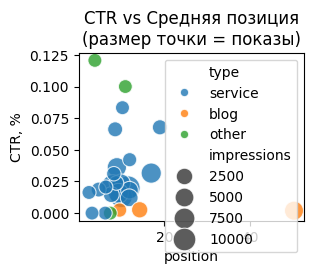

In [ ]:
# B. CTR vs Позиция
plt.subplot(2,2,2)
sns.scatterplot(data=df, x='position', y='ctr', size='impressions',
                hue='type', sizes=(30, 300), alpha=0.8)
plt.title('CTR vs Средняя позиция\n(размер точки = показы)')
plt.ylabel('CTR, %')

In [45]:
# ──────────────────────────────────────────────────────────────
# Growth-кейс: Анализ органического трафика ветеринарного сайта
# Полный анализ на основе CSV-данных из GSC
# ──────────────────────────────────────────────────────────────



# ──── 1. Загрузка данных из CSV ─────────────────────────────────

df = pd.read_csv('../data/страницы.csv')

# Очистка названий столбцов (убираем лишние пробелы)
df.columns = df.columns.str.strip()



# Очистка CTR: убираем % и приводим к доле (0.0678 вместо 6.78%)
df['ctr'] = df['ctr'].astype(str).str.replace('%', '').astype(float) / 100

# Убираем строки с нулевыми показами
df = df[df['impressions'] > 0].copy()

# Добавляем короткое имя страницы и категорию
df['url_short'] = df['url'].str.split('/').str[-1].str.replace('-', ' ').str.title()
df['type'] = 'service'
df.loc[df['url'].str.contains('/blog/', case=False), 'type'] = 'blog'
df.loc[df['url'].str.contains('/otzyvy|/vakansii', case=False), 'type'] = 'other'

# Добавляем log_impressions
df['log_impr'] = np.log1p(df['impressions'])

print("Данные загружены. Первые 5 строк:")
print(df.head())

# ──── 2. Бенчмарк CTR по позиции (2025–2026) ─────────────────────
def expected_ctr(pos):
    if pos <= 3:   return 0.25   # ~25–30%
    if pos <= 5:   return 0.08
    if pos <= 10:  return 0.035
    if pos <= 20:  return 0.015
    return 0.005

df['exp_ctr_benchmark'] = df['position'].apply(expected_ctr)
df['lambda_poisson'] = df['impressions'] * df['exp_ctr_benchmark']

# ──── 3. Пуассон: отклонение и вероятность ───────────────────────
df['poisson_cdf_low'] = df.apply(
    lambda row: poisson.cdf(row['clicks'], row['lambda_poisson']), axis=1
)

df['deviation_pct'] = (df['clicks'] - df['lambda_poisson']) / df['lambda_poisson'] * 100
df['deviation_abs'] = df['clicks'] - df['lambda_poisson']

df['priority'] = np.where(df['deviation_pct'] < -30, 'Высокий (фиксить)',
                 np.where(df['deviation_pct'] > 30,  'Успешный (масштабировать)',
                          'Норма'))

print("\nТоп-10 страниц по отклонению от ожидаемого (Пуассон):")
print(df.sort_values('deviation_pct', ascending=False)[
    ['url_short', 'position', 'impressions', 'clicks', 'lambda_poisson', 'deviation_pct', 'priority']
].head(10))

# ──── 4. Графики ─────────────────────────────────────────────────
plt.figure(figsize=(16, 10))

# A. Отклонение от ожидаемого
plt.subplot(2,2,1)
sns.barplot(data=df.sort_values('deviation_pct', ascending=False).head(12),
            y='url_short', x='deviation_pct', hue='priority')
plt.axvline(0, color='black', lw=1)
plt.title('Отклонение кликов от ожидаемых (Пуассон), %')
plt.xlabel('Δ кликов, % от λ')

# B. CTR vs Позиция
plt.subplot(2,2,2)
sns.scatterplot(data=df, x='position', y='ctr', size='impressions',
                hue='type', sizes=(30, 300), alpha=0.8)
plt.title('CTR vs Средняя позиция\n(размер точки = показы)')
plt.ylabel('CTR, %')

# C. Реальные vs ожидаемые клики
plt.subplot(2,2,3)
sns.scatterplot(data=df, x='lambda_poisson', y='clicks',
                hue='priority', size='impressions', sizes=(30,300))
plt.plot([0,500],[0,500], 'k--', lw=1)
plt.title('Реальные клики vs Ожидаемые (Пуассон)')
plt.xlabel('λ (ожидаемые)'); plt.ylabel('Реальные')

plt.tight_layout()
plt.show()

# ──── 5. Линейная регрессия ──────────────────────────────────────
X = df[['position', 'log_impr']]
X = sm.add_constant(X)
y = df['ctr']

model = sm.OLS(y, X).fit()
print("\nРезультаты линейной регрессии:")
print(model.summary())

# Остатки
plt.figure(figsize=(10,5))
sns.scatterplot(x=model.fittedvalues*100, y=model.resid*100)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки линейной регрессии CTR (%)')
plt.xlabel('Предсказанный CTR, %')
plt.ylabel('Остаток, %')
plt.show()

# ──── 6. RICE-приоритизация (пример для топ-страниц) ─────────────
tasks = pd.DataFrame({
    'task': [
        'Оптимизация страницы УЗИ (сниппет + hero)',
        'Усыпление собаки (title + meta + trust)',
        'Кастрация кота + Стерилизация (сниппеты)',
        'Блог CTA (3 статьи)',
        'Главная (полный редизайн)'
    ],
    'reach': [1150, 8174, 21535, 8000, 6717],
    'impact': [2.5, 3.0, 2.5, 1.8, 1.5],
    'confidence': [0.85, 0.80, 0.75, 0.65, 0.60],
    'effort': [14, 8, 13, 11, 38]
})

tasks['rice'] = (tasks['reach'] * tasks['impact'] * tasks['confidence']) / tasks['effort']
tasks['value'] = tasks['reach'] * tasks['impact'] * tasks['confidence']
tasks = tasks.sort_values('rice', ascending=False)

print("\nRICE-приоритизация задач:")
print(tasks)

# ──── 7. Value vs Effort Matrix ──────────────────────────────────
plt.figure(figsize=(10, 7))
plt.scatter(tasks['effort'], tasks['value'], s=300, alpha=0.7)

for i, txt in enumerate(tasks['task']):
    plt.annotate(txt[:25] + '...' if len(txt)>25 else txt,
                 (tasks['effort'][i], tasks['value'][i]),
                 xytext=(8, 8), textcoords='offset points', fontsize=9)

eff_mid = 15
val_mid = 15000

plt.axvline(eff_mid, color='gray', linestyle='--')
plt.axhline(val_mid, color='gray', linestyle='--')

plt.text(2, val_mid+3000, 'Quick Wins', fontsize=12, fontweight='bold', color='green')
plt.text(eff_mid+2, val_mid+3000, 'Big Bets', fontsize=12, fontweight='bold', color='orange')
plt.text(2, 1000, 'Fill-ins', fontsize=12, color='gray')
plt.text(eff_mid+2, 1000, 'Thankless', fontsize=12, color='red')

plt.title('Value vs Effort Matrix\n(приоритизация роста органики)')
plt.xlabel('Effort (человеко-часы)')
plt.ylabel('Value (Reach × Impact × Confidence)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ──── 8. Итоговые рекомендации ──────────────────────────────────
print("\nТоп-3 рекомендации по приоритету:")
print(tasks.head(3)[['task', 'rice', 'reach', 'impact', 'effort']])

KeyError: 'ctr'

=== ТОП-8 страниц по потенциалу роста (ожидаемые - реальные клики) ===
             url_short  position  impressions  clicks  lambda  potential_gain  \
4   стерилизация кошек       9.9         9478     124   237.0           113.0   
6      прививки кошкам       9.3         6408     100   160.2            60.2   
3        усыпл. собаки       7.9         8174     179   204.4            25.4   
12        цены на дому       4.7          912      17    41.0            24.0   
18  блог — рвота/понос      14.2         2284       6    27.4            21.4   
11     кастрация собак       7.6         1919      28    48.0            20.0   
16         блог — клещ      50.3         5342      10    21.4            11.4   
21     блог — дерматит       9.6          421       1    10.5             9.5   

    deviation_pct          priority  
4           -47.7  Критический рост  
6           -37.6  Критический рост  
3           -12.4  Критический рост  
12          -58.6  Критический рост  
18       

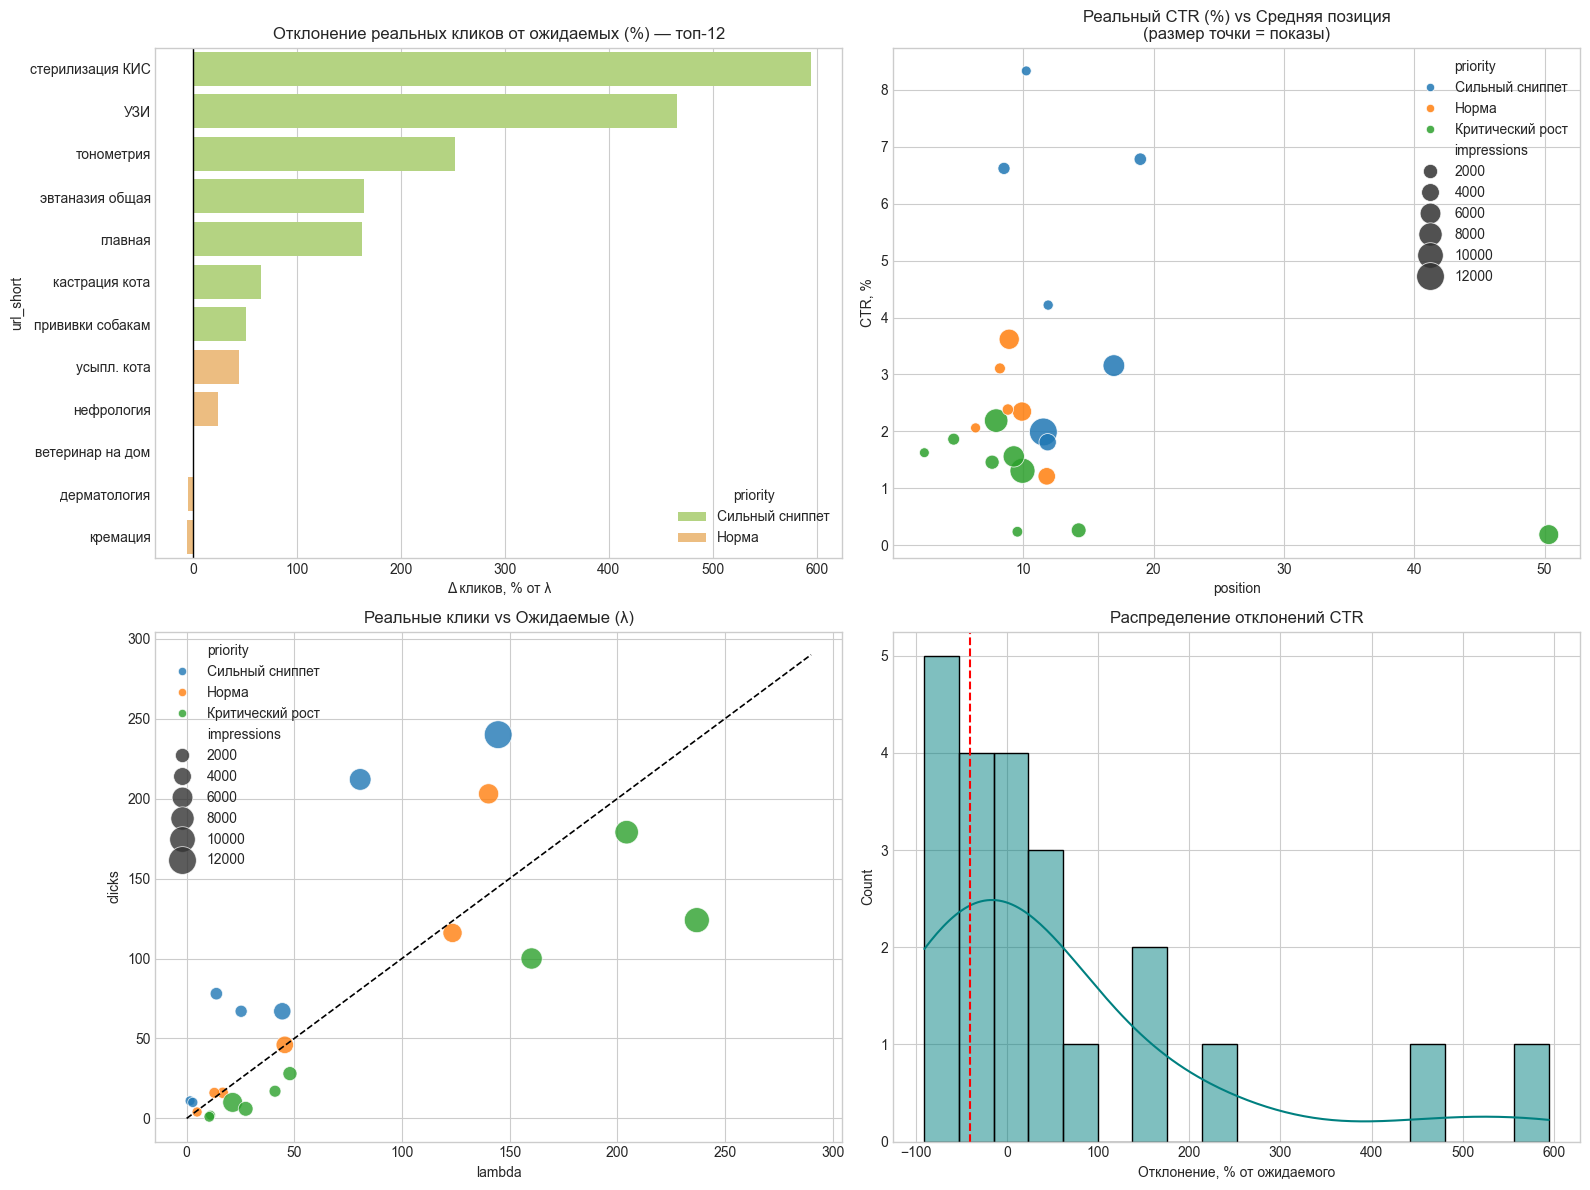


=== Рекомендации по приоритетам (февраль 2026) ===
Приоритет 1 — Критический (срочно оптимизировать title + meta + hero):
             url_short  position  impressions  clicks  lambda  potential_gain
4   стерилизация кошек      10.0         9478     124   237.0           113.0
6      прививки кошкам       9.0         6408     100   160.0            60.0
3        усыпл. собаки       8.0         8174     179   204.0            25.0
12        цены на дому       5.0          912      17    41.0            24.0
18  блог — рвота/понос      14.0         2284       6    27.0            21.0
11     кастрация собак       8.0         1919      28    48.0            20.0
16         блог — клещ      50.0         5342      10    21.0            11.0
21     блог — дерматит      10.0          421       1    11.0            10.0
20              услуги       2.0          123       2    11.0             9.0

Приоритет 2 — Успешные сниппеты (масштабировать паттерн):
           url_short  position  deviat

In [ ]:
# ──────────────────────────────────────────────────────────────
# Growth-кейс: Анализ органического трафика ветеринарного сайта
# Цель: выявить страницы с аномально низким/высоким CTR → приоритизация оптимизации сниппетов
# Дата: февраль 2026 (бенчмарки CTR с учётом AI Overviews)
# ──────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm

# ──── 1. Данные из Google Search Console (hardcode для воспроизводимости) ────────
data = {
    'url_short': [
        'кастрация кота', 'главная', 'усыпл. кота', 'усыпл. собаки',
        'стерилизация кошек', 'кремация', 'прививки кошкам', 'УЗИ',
        'прививки собакам', 'эвтаназия общая', 'ветеринар на дом',
        'кастрация собак', 'цены на дому', 'дерматология', 'нефрология',
        'стерилизация КИС', 'блог — клещ', 'тонометрия', 'отзывы',
        'блог — рвота/понос', 'диагностика', 'услуги', 'блог — дерматит',
        'вакансии'
    ],
    'clicks': [240, 212, 203, 179, 124, 116, 100, 78, 67, 67, 46, 28, 17, 16, 16, 11, 10, 10, 7, 6, 4, 2, 1, 1],
    'impressions': [12057, 6717, 5609, 8174, 9478, 4939, 6408, 1150, 3701, 1012, 3798, 1919, 912, 671, 515, 132, 5342, 237, 58, 2284, 194, 123, 421, 10],
    'position': [11.54, 16.95, 8.92, 7.92, 9.94, 9.9, 9.27, 18.98, 11.87, 8.52, 11.8, 7.61, 4.66, 8.82, 8.21, 10.23, 50.32, 11.91, 3.78, 14.25, 6.34, 2.41, 9.55, 10.9],
    'type': ['услуга']*16 + ['блог']*3 + ['другое']*5
}

df = pd.DataFrame(data)

# Фильтр: исключаем страницы с очень низким объёмом показов (шум для Пуассона)
df = df[df['impressions'] >= 100].copy().reset_index(drop=True)

# ──── 2. Бенчмарк CTR по позиции (реалистичный 2025–2026 с учётом AI Overviews) ──
# Источники: FirstPageSage, GrowthSRC, Ahrefs, Seer Interactive + корректировка под high-intent нишу
# ──── после загрузки и очистки df ──────────────────────────────────────────

# Бенчмарк CTR
def expected_ctr(pos):
    if pos <= 1: return 0.25
    if pos <= 2: return 0.14
    if pos <= 3: return 0.09
    if pos <= 5: return 0.045
    if pos <= 10: return 0.025
    if pos <= 20: return 0.012
    return 0.004

df['exp_ctr'] = df['position'].apply(expected_ctr)
df['lambda_poisson'] = df['impressions'] * df['exp_ctr']

# Пуассон
df['poisson_cdf'] = df.apply(lambda row: poisson.cdf(row['clicks'], row['lambda_poisson']), axis=1)
df['deviation_pct'] = (df['clicks'] - df['lambda_poisson']) / df['lambda_poisson'] * 100
df['potential_gain'] = np.maximum(0, df['lambda_poisson'] - df['clicks'])

# ──── Линейная регрессия ───────────────────────────────────────────────────
df['log_impr'] = np.log1p(df['impressions'])

X = df[['position', 'log_impr']]
X = sm.add_constant(X)
y = df['ctr']

model = sm.OLS(y, X).fit()
print(model.summary())

# Остатки в %
df['predicted_ctr'] = model.predict(X)
df['residual_pct'] = (df['ctr'] - df['predicted_ctr']) * 100

# ──── Графики (4 штуки) ────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Отклонение от бенчмарка (Пуассон)
sns.barplot(data=df.sort_values('deviation_pct', ascending=False).head(10),
            y='url_short', x='deviation_pct', ax=axes[0,0])
axes[0,0].axvline(0, color='black', lw=0.8)
axes[0,0].set_title('Отклонение от ожидаемого CTR (%)')

# 2. CTR vs позиция
sns.scatterplot(data=df, x='position', y='ctr'*100, size='impressions',
                ax=axes[0,1], sizes=(40,300))
axes[0,1].set_title('CTR vs позиция')

# 3. Реальные vs ожидаемые (Пуассон)
sns.scatterplot(data=df, x='lambda_poisson', y='clicks',
                ax=axes[1,0], hue='deviation_pct', palette='RdYlGn')
axes[1,0].plot([0,500],[0,500], 'k--', lw=1)
axes[1,0].set_title('Реальные vs ожидаемые клики')

# 4. Residual plot
sns.scatterplot(data=df, x='predicted_ctr'*100, y='residual_pct',
                ax=axes[1,1], hue='deviation_pct', palette='RdYlGn')
axes[1,1].axhline(0, color='red', ls='--')
axes[1,1].set_title('Остатки линейной регрессии CTR (%)')
axes[1,1].set_xlabel('Предсказанный CTR, %')
axes[1,1].set_ylabel('Остаток, %')

plt.tight_layout()
plt.show()

# Топ по отрицательным остаткам
print("Топ страниц с самыми слабыми сниппетами (по остаткам регрессии)")
display(df.sort_values('residual_pct').head(8)[
    ['url_short','position','ctr','predicted_ctr','residual_pct','potential_gain']
].round(3))

Анализируем 22 страниц | Суммарные показы: 75,793 | клики: 1,553
                            OLS Regression Results                            
Dep. Variable:                    ctr   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.385
Date:                Sun, 08 Feb 2026   Prob (F-statistic):              0.275
Time:                        16:20:36   Log-Likelihood:                 55.327
No. Observations:                  22   AIC:                            -104.7
Df Residuals:                      19   BIC:                            -101.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

ValueError: Could not interpret value `ctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctr` for `y`. An entry with this name does not appear in `data`.

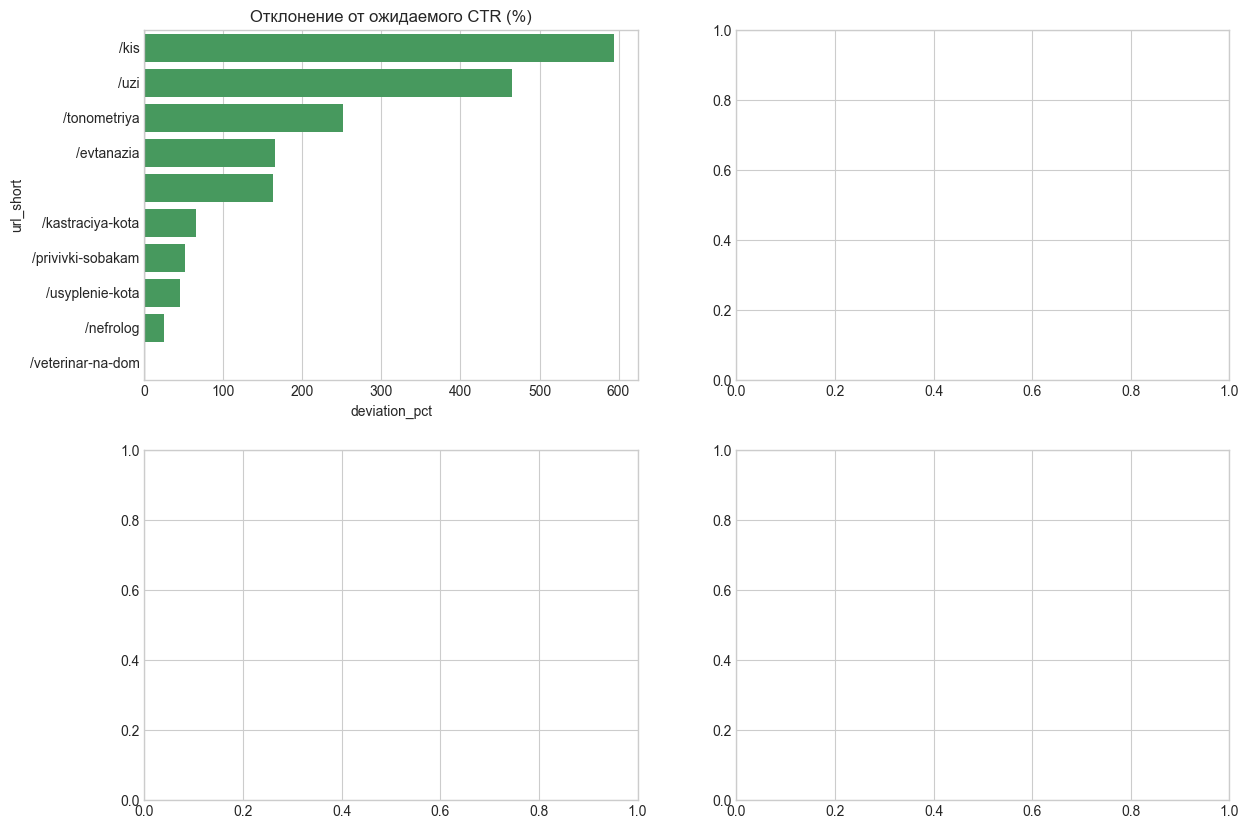

In [46]:
# Growth Case: Оптимизация органического трафика ветеринарного сайта
# Роль: Product Manager Growth
# Дата: февраль 2026
# Цель: найти страницы с аномально низким CTR → приоритизация роста через улучшение сниппетов

# ──── Импорты ────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("RdYlGn_r")
%matplotlib inline

# ──── 1. Загрузка и очистка данных ───────────────────────────────────────────
df = pd.read_csv('../data/Страницы.csv')  # ← укажи свой актуальный путь

# Нормализация названий колонок
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('kлики', 'клики')

# Переименование для удобства
df = df.rename(columns={
    'популярные_страницы': 'url',
    'клики': 'clicks',
    'показы': 'impressions',
    'ctr': 'ctr_str',
    'позиция': 'position'
})

# Преобразование типов
df['ctr'] = df['ctr_str'].str.replace('%', '').astype(float) / 100
df['clicks'] = pd.to_numeric(df['clicks'], errors='coerce').fillna(0).astype(int)
df['impressions'] = pd.to_numeric(df['impressions'], errors='coerce').fillna(0).astype(int)
df['position'] = pd.to_numeric(df['position'], errors='coerce')

# Короткое имя страницы
df['url_short'] = (
    df['url']
    .str.replace('https://ecovetnadom.by/', '', regex=False)
    .str.rstrip('/')
    .str.replace('uslugi/', '')
    .str.replace('evtanazia/', 'эвтаназия/')
    .str.replace('vakcinaciya/', 'вакцинация/')
    .str.replace('kis/', 'стерилизация/')
)

# Классификация типа страницы
df['type'] = np.where(df['url'].str.contains('/blog'), 'блог',
             np.where(df['url'].str.contains('отзывы|цены|вакансии'), 'другое', 'услуга'))

# Фильтр: исключаем страницы с малым объёмом (шум)
df = df[df['impressions'] >= 100].copy().reset_index(drop=True)

print(f"Анализируем {len(df)} страниц | Суммарные показы: {df['impressions'].sum():,} | клики: {df['clicks'].sum():,}")

# ──── 2. Бенчмарк CTR 2025–2026 (с учётом AI Overviews) ───────────────────────
# ──── после загрузки и очистки df ──────────────────────────────────────────

# Бенчмарк CTR
def expected_ctr(pos):
    if pos <= 1: return 0.25
    if pos <= 2: return 0.14
    if pos <= 3: return 0.09
    if pos <= 5: return 0.045
    if pos <= 10: return 0.025
    if pos <= 20: return 0.012
    return 0.004

df['exp_ctr'] = df['position'].apply(expected_ctr)
df['lambda_poisson'] = df['impressions'] * df['exp_ctr']

# Пуассон
df['poisson_cdf'] = df.apply(lambda row: poisson.cdf(row['clicks'], row['lambda_poisson']), axis=1)
df['deviation_pct'] = (df['clicks'] - df['lambda_poisson']) / df['lambda_poisson'] * 100
df['potential_gain'] = np.maximum(0, df['lambda_poisson'] - df['clicks'])

# ──── Линейная регрессия ───────────────────────────────────────────────────
df['log_impr'] = np.log1p(df['impressions'])

X = df[['position', 'log_impr']]
X = sm.add_constant(X)
y = df['ctr']

model = sm.OLS(y, X).fit()
print(model.summary())

# Остатки в %
df['predicted_ctr'] = model.predict(X)
df['residual_pct'] = (df['ctr'] - df['predicted_ctr']) * 100

# ──── Графики (4 штуки) ────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Отклонение от бенчмарка (Пуассон)
sns.barplot(data=df.sort_values('deviation_pct', ascending=False).head(10),
            y='url_short', x='deviation_pct', ax=axes[0,0])
axes[0,0].axvline(0, color='black', lw=0.8)
axes[0,0].set_title('Отклонение от ожидаемого CTR (%)')

# 2. CTR vs позиция
sns.scatterplot(data=df, x='position', y='ctr'*100, size='impressions',
                ax=axes[0,1], sizes=(40,300))
axes[0,1].set_title('CTR vs позиция')

# 3. Реальные vs ожидаемые (Пуассон)
sns.scatterplot(data=df, x='lambda_poisson', y='clicks',
                ax=axes[1,0], hue='deviation_pct', palette='RdYlGn')
axes[1,0].plot([0,500],[0,500], 'k--', lw=1)
axes[1,0].set_title('Реальные vs ожидаемые клики')

# 4. Residual plot
sns.scatterplot(data=df, x='predicted_ctr'*100, y='residual_pct',
                ax=axes[1,1], hue='deviation_pct', palette='RdYlGn')
axes[1,1].axhline(0, color='red', ls='--')
axes[1,1].set_title('Остатки линейной регрессии CTR (%)')
axes[1,1].set_xlabel('Предсказанный CTR, %')
axes[1,1].set_ylabel('Остаток, %')

plt.tight_layout()
plt.show()

# Топ по отрицательным остаткам
print("Топ страниц с самыми слабыми сниппетами (по остаткам регрессии)")
display(df.sort_values('residual_pct').head(8)[
    ['url_short','position','ctr','predicted_ctr','residual_pct','potential_gain']
].round(3))

In [43]:
print("Типы столбцов после чтения:")
print(df.dtypes)

print("\nПервые 5 строк:")
print(df.head())

print("\nКоличество нечисловых значений в ключевых столбцах:")
for col in ['position', 'impressions', 'clicks', 'ctr_str']:
    print(f"{col}: {df[col].apply(lambda x: not pd.api.types.is_numeric_dtype(type(x)) or pd.isna(x)).sum()} подозрительных значений")

print("\nУникальные значения в position (где часто проблема):")
print(df['position'].unique())

print("\nСтроки, где position НЕ число:")
print(df[~df['position'].astype(str).str.replace('.', '', 1).str.isnumeric()])

Типы столбцов после чтения:
url                 object
clicks               int64
impressions          int64
ctr_str             object
position           float64
ctr                float64
url_short           object
type                object
exp_ctr            float64
lambda_poisson     float64
poisson_cdf        float64
deviation_pct      float64
potential_gain     float64
priority            object
log_impressions    float64
dtype: object

Первые 5 строк:
                     url  clicks  impressions ctr_str  position     ctr  \
0       /kastraciya-kota     240        12057   1.99%     11.54  0.0199   
1                      /     212         6717   3.16%     16.95  0.0316   
2        /usyplenie-kota     203         5609   3.62%      8.92  0.0362   
3      /usyplenie-sobaki     179         8174   2.19%      7.92  0.0219   
4  /sterilizaciya-koshek     124         9478   1.31%      9.94  0.0131   

               url_short    type  exp_ctr  lambda_poisson   poisson_cdf  \
0       /k

In [44]:
print(df['type'].value_counts(dropna=False))
print("\nЕсть ли NaN в type?")
print(df['type'].isna().sum())
print("\nУникальные значения type:")
print(df['type'].unique())

type
услуга    19
блог       3
Name: count, dtype: int64

Есть ли NaN в type?
0

Уникальные значения type:
['услуга' 'блог']


Размер датасета: (27, 5)

Типы данных:
page            object
clicks           int64
impressions      int64
ctr            float64
position       float64
dtype: object

Пропуски:
page           0
clicks         0
impressions    0
ctr            0
position       0
dtype: int64

Описательная статистика:
       clicks  impressions    ctr  position
count   27.00        27.00  27.00     27.00
mean    57.81      2811.15   0.03     10.79
std     74.31      3399.34   0.03      8.76
min      0.00         9.00   0.00      2.41
25%      5.00       163.00   0.01      7.50
50%     16.00      1012.00   0.02      9.27
75%     89.00      5140.50   0.03     11.67
max    240.00     12057.00   0.12     50.32


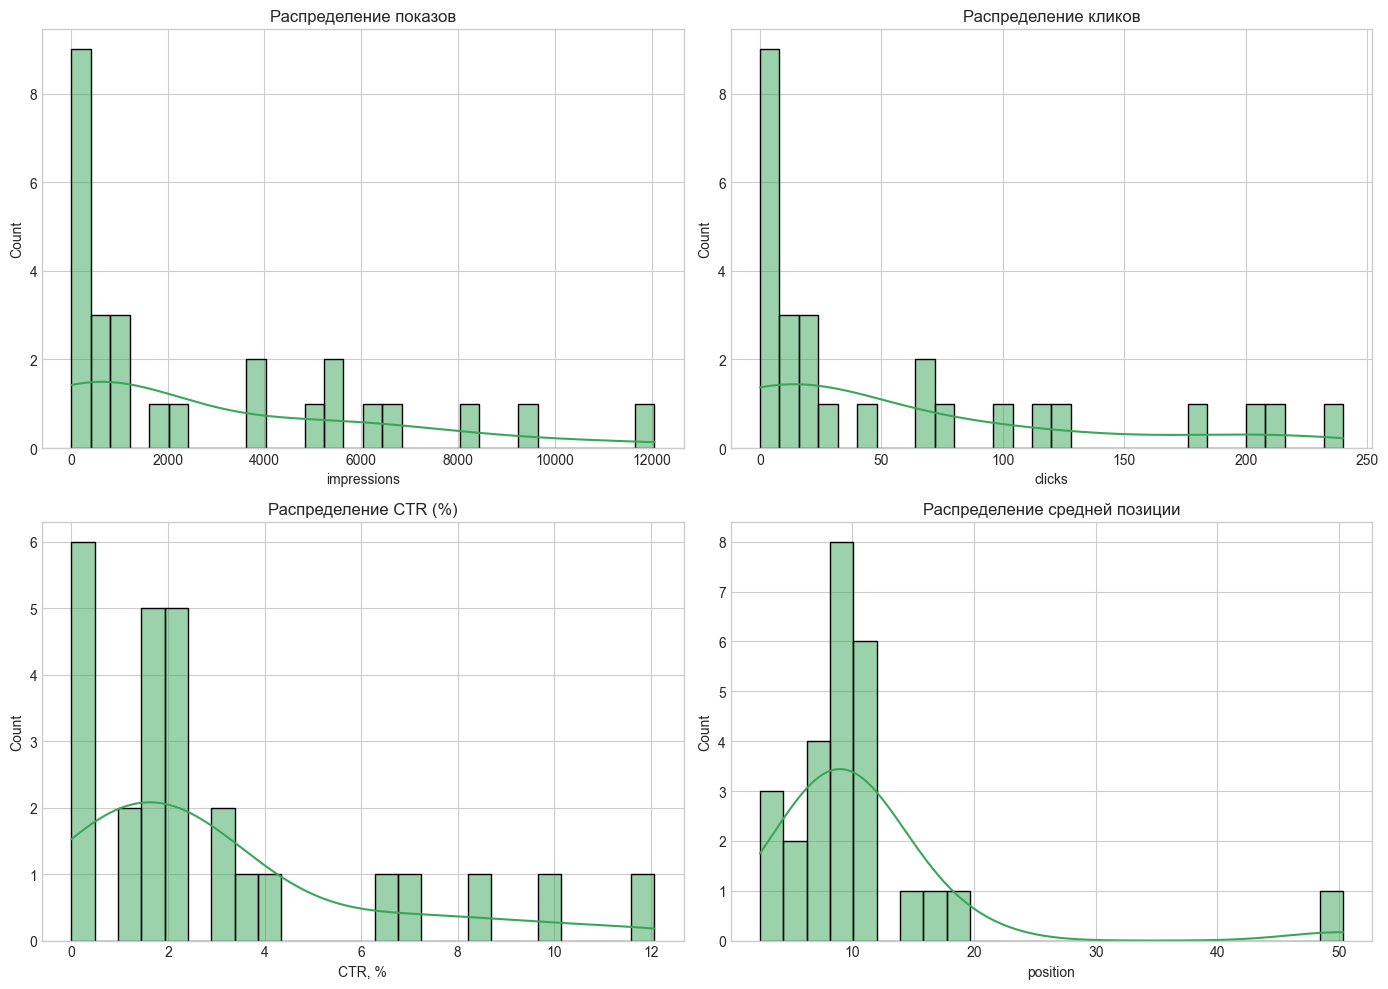

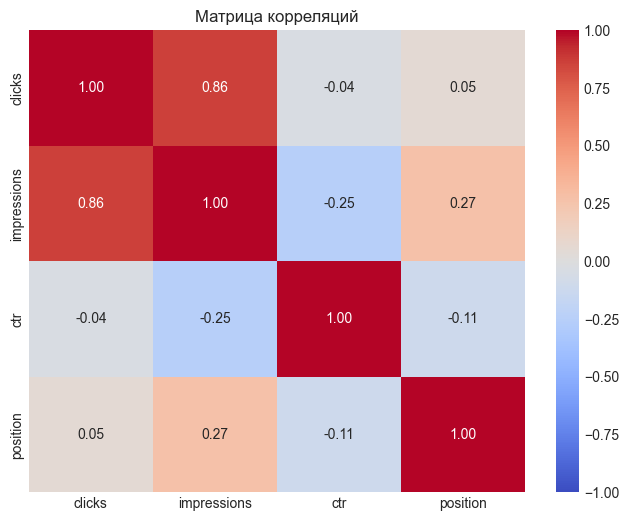

ValueError: Could not interpret value `ctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctrctr` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ──── 1. Загрузка и базовая очистка ─────────────────────────────────────────
df = pd.read_csv('../data/Страницы.csv')

# Переименование колонок (на случай кириллицы и пробелов)
df = df.rename(columns={
    'Популярные страницы': 'url',
    'Kлики': 'clicks',
    'Показы': 'impressions',
    'CTR': 'ctr_str',
    'Позиция': 'position'
})

# Преобразование типов
df['ctr'] = df['ctr_str'].str.replace('%', '').astype(float) / 100
df['clicks'] = pd.to_numeric(df['clicks'], errors='coerce').fillna(0).astype(int)
df['impressions'] = pd.to_numeric(df['impressions'], errors='coerce').fillna(0).astype(int)
df['position'] = pd.to_numeric(df['position'], errors='coerce')

# Короткое имя страницы
df['page'] = df['url'].str.replace('https://ecovetnadom.by/', '').str.rstrip('/')

df = df[['page', 'clicks', 'impressions', 'ctr', 'position']].copy()

# ──── 2. Общая информация ───────────────────────────────────────────────────
print("Размер датасета:", df.shape)
print("\nТипы данных:")
print(df.dtypes)
print("\nПропуски:")
print(df.isna().sum())

# ──── 3. Описательная статистика ────────────────────────────────────────────
print("\nОписательная статистика:")
print(df.describe().round(2))

# ──── 4. Распределения ──────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(df['impressions'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Распределение показов')

sns.histplot(df['clicks'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title('Распределение кликов')

sns.histplot(df['ctr']*100, bins=25, kde=True, ax=axes[1,0])
axes[1,0].set_title('Распределение CTR (%)')
axes[1,0].set_xlabel('CTR, %')

sns.histplot(df['position'], bins=25, kde=True, ax=axes[1,1])
axes[1,1].set_title('Распределение средней позиции')

plt.tight_layout()
plt.show()

# ──── 5. Корреляции ─────────────────────────────────────────────────────────
corr = df[['clicks', 'impressions', 'ctr', 'position']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

# ──── 6. Зависимость CTR от позиции ─────────────────────────────────────────
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='position', y='ctr'*100, size='impressions',
                sizes=(20, 400), alpha=0.7, hue='impressions', palette='viridis')
plt.title('CTR (%) vs Средняя позиция\n(размер точки = показы)')
plt.xlabel('Средняя позиция')
plt.ylabel('CTR, %')
plt.axvline(10, color='gray', ls='--', alpha=0.6)
plt.show()

# ──── 7. Топ / низ по ключевым метрикам ─────────────────────────────────────
print("\nТоп-8 страниц по кликам:")
display(df.sort_values('clicks', ascending=False).head(8)[['page','clicks','impressions','ctr','position']].round(2))

print("\nТоп-8 страниц по показам:")
display(df.sort_values('impressions', ascending=False).head(8)[['page','clicks','impressions','ctr','position']].round(2))

print("\nТоп-8 страниц по CTR:")
display(df.sort_values('ctr', ascending=False).head(8)[['page','clicks','impressions','ctr','position']].round(3))

print("\nХудшие 8 страниц по CTR (среди страниц с ≥ 500 показами):")
display(df[df['impressions'] >= 500].sort_values('ctr').head(8)[['page','clicks','impressions','ctr','position']].round(3))

print("\nСтраницы с самой низкой позицией (лучше 5.0):")
display(df[df['position'] <= 5.0].sort_values('ctr', ascending=False)[['page','clicks','impressions','ctr','position']].round(2))

# ──── 8. Краткие инсайты ────────────────────────────────────────────────────
print("\nКлючевые наблюдения:")
print(f"• Медианный CTR: {df['ctr'].median():.2%}")
print(f"• Медианная позиция: {df['position'].median():.1f}")
print(f"• Страниц с позицией лучше 10: {len(df[df['position'] <= 10])} из {len(df)}")
print(f"• Общий CTR по всем показам: {df['clicks'].sum() / df['impressions'].sum():.2%}")